In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import math

In [2]:
df = pd.read_csv("enhanced_anxiety_dataset.csv")
#Drop Stress Level as this risks overpowering the rest of the predictors
df = df.drop(columns=["Stress Level (1-10)"])
#Check for missing values
print(df.isnull().values.any())
#No missing values, so now we want to standardize the categoricals, ie make all Yes and No yes and no
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.lower()
df.head()

False


,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,female,artist,6.0,2.7,181,10,yes,no,114,14,4,no,yes,3,yes,7,5.0
1,46,other,nurse,6.2,5.7,200,8,yes,yes,62,23,2,yes,no,2,no,8,3.0
2,64,male,other,5.0,3.7,117,4,no,yes,91,28,3,no,no,1,yes,1,1.0
3,20,female,scientist,5.8,2.8,360,6,yes,no,86,17,3,no,no,0,no,1,2.0
4,49,female,other,8.2,2.3,247,4,yes,no,98,19,4,yes,yes,1,no,3,1.0


In [3]:
#Intro EDA, describe numerical columns
print(df.describe())
#Describe categorical columns
for col in df.select_dtypes(include='object').columns:
    print(f"\n       {col}")
    print(df[col].value_counts())

                Age   Sleep Hours  Physical Activity (hrs/week)  \
count  11000.000000  11000.000000                  11000.000000   
mean      40.241727      6.650691                      2.942136   
std       13.236140      1.227509                      1.827825   
min       18.000000      2.300000                      0.000000   
25%       29.000000      5.900000                      1.500000   
50%       40.000000      6.700000                      2.800000   
75%       51.000000      7.500000                      4.200000   
max       64.000000     11.300000                     10.100000   

       Caffeine Intake (mg/day)  Alcohol Consumption (drinks/week)  \
count              11000.000000                       11000.000000   
mean                 286.090000                           9.701636   
std                  144.813157                           5.689713   
min                    0.000000                           0.000000   
25%                  172.000000               

/var/folders/g3/r7bljwyn7y76zncr_nl6fglr0000gn/T/ipykernel_97609/824832645.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Anxiety Level (1-10)', data=df, palette='plasma_r')


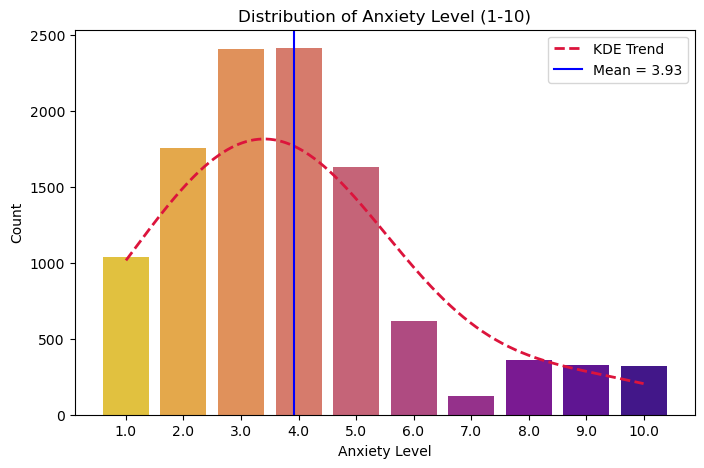

In [4]:
#Get mean
mean_anxiety = df['Anxiety Level (1-10)'].mean()

#Counts for trend curve
counts = df['Anxiety Level (1-10)'].value_counts().sort_index()
x = counts.index.values
y = counts.values

#Fit the trend KDE curve scaled to counts
kde = gaussian_kde(x, weights=y)
x_smooth = np.linspace(x.min(), x.max(), 400)
y_smooth = kde(x_smooth) * len(df['Anxiety Level (1-10)']) * (x[1] - x[0])

plt.figure(figsize=(8, 5))
sns.countplot(x='Anxiety Level (1-10)', data=df, palette='plasma_r')

#Plot the curve
plt.plot(x_smooth - 1, y_smooth, color='crimson', linestyle='--', linewidth=2, label='KDE Trend')

#Plot the mean
plt.axvline(mean_anxiety - 1, color='blue', linestyle='-', label=f'Mean = {mean_anxiety:.2f}')

plt.title('Distribution of Anxiety Level (1-10)')
plt.xlabel('Anxiety Level')
plt.ylabel('Count')
plt.legend()
plt.show()

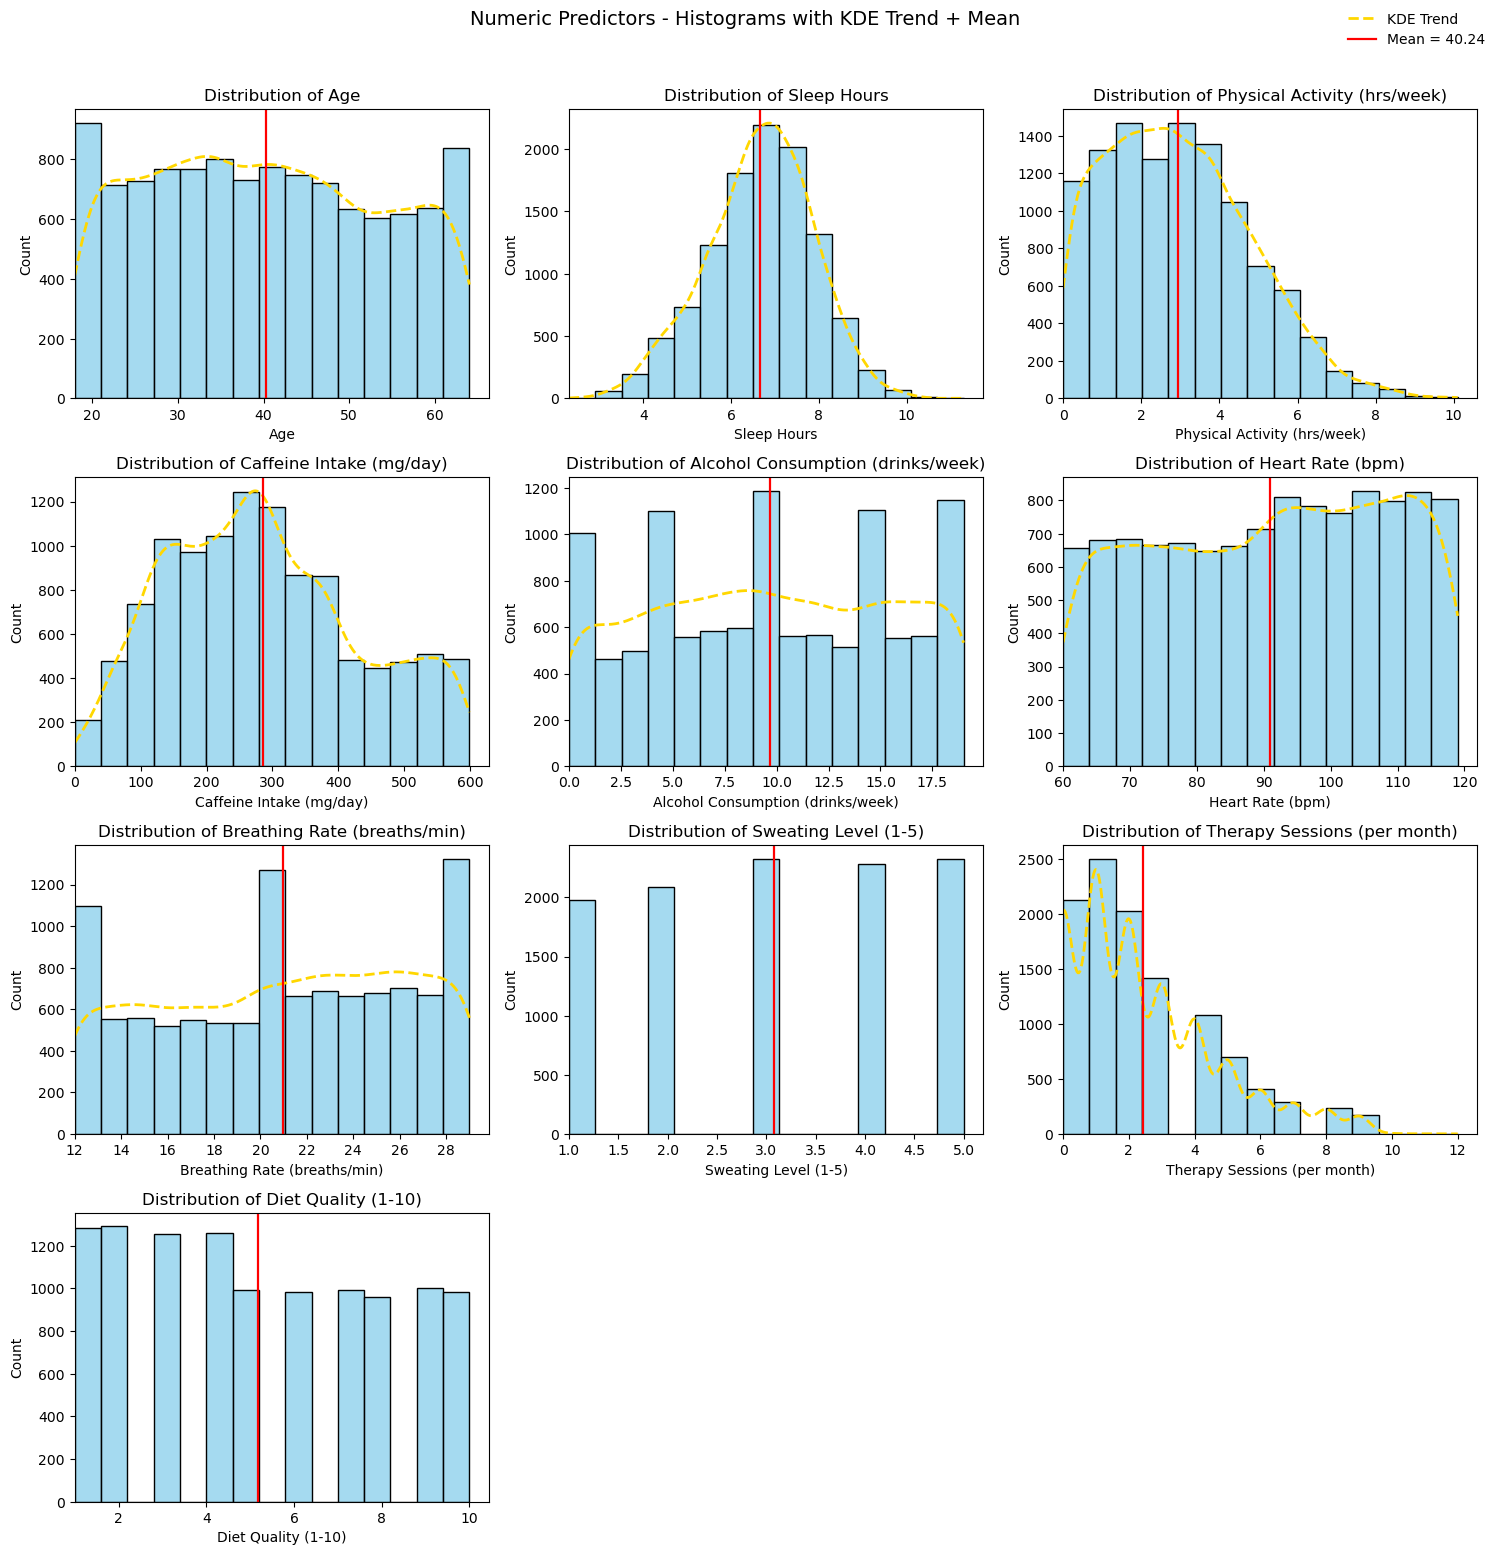

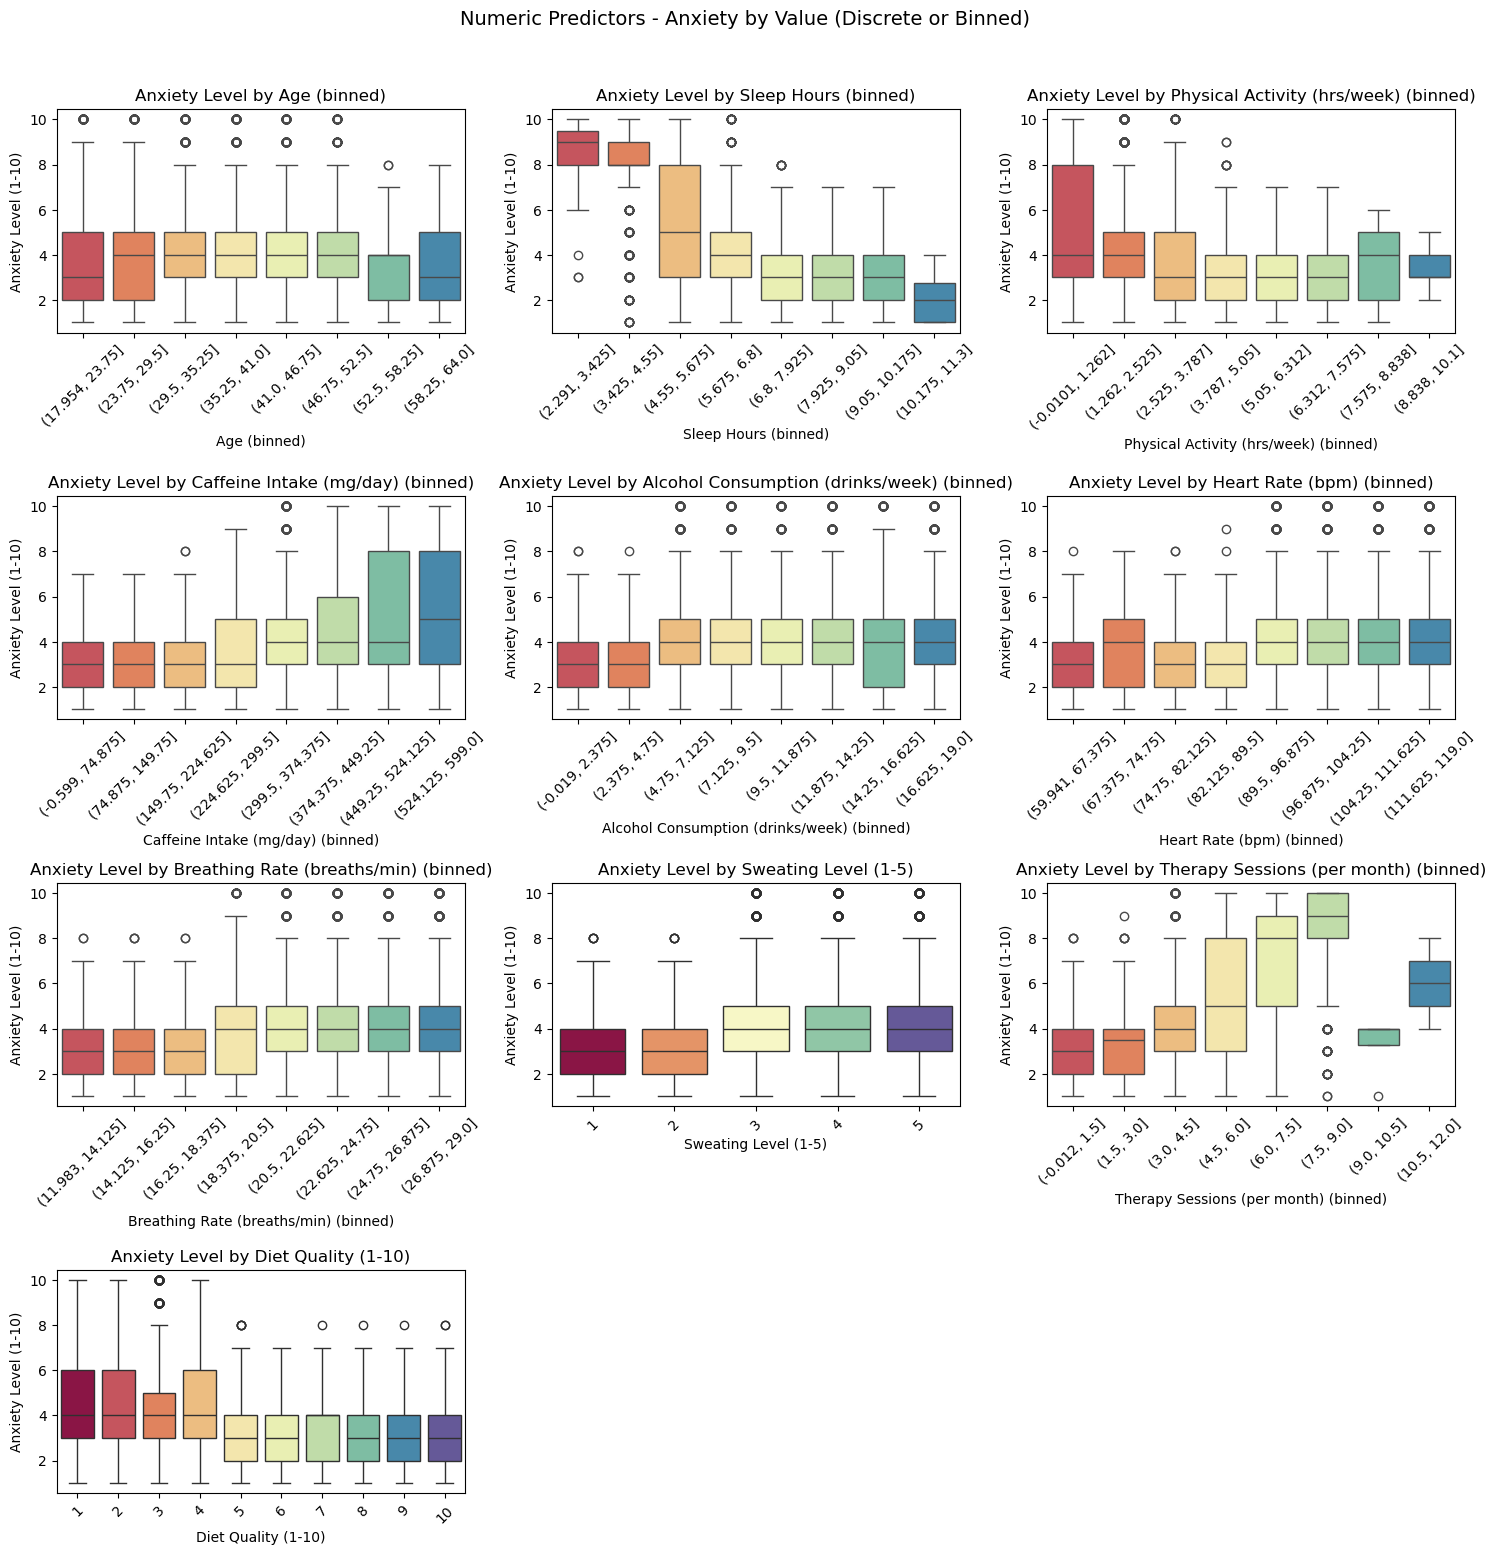

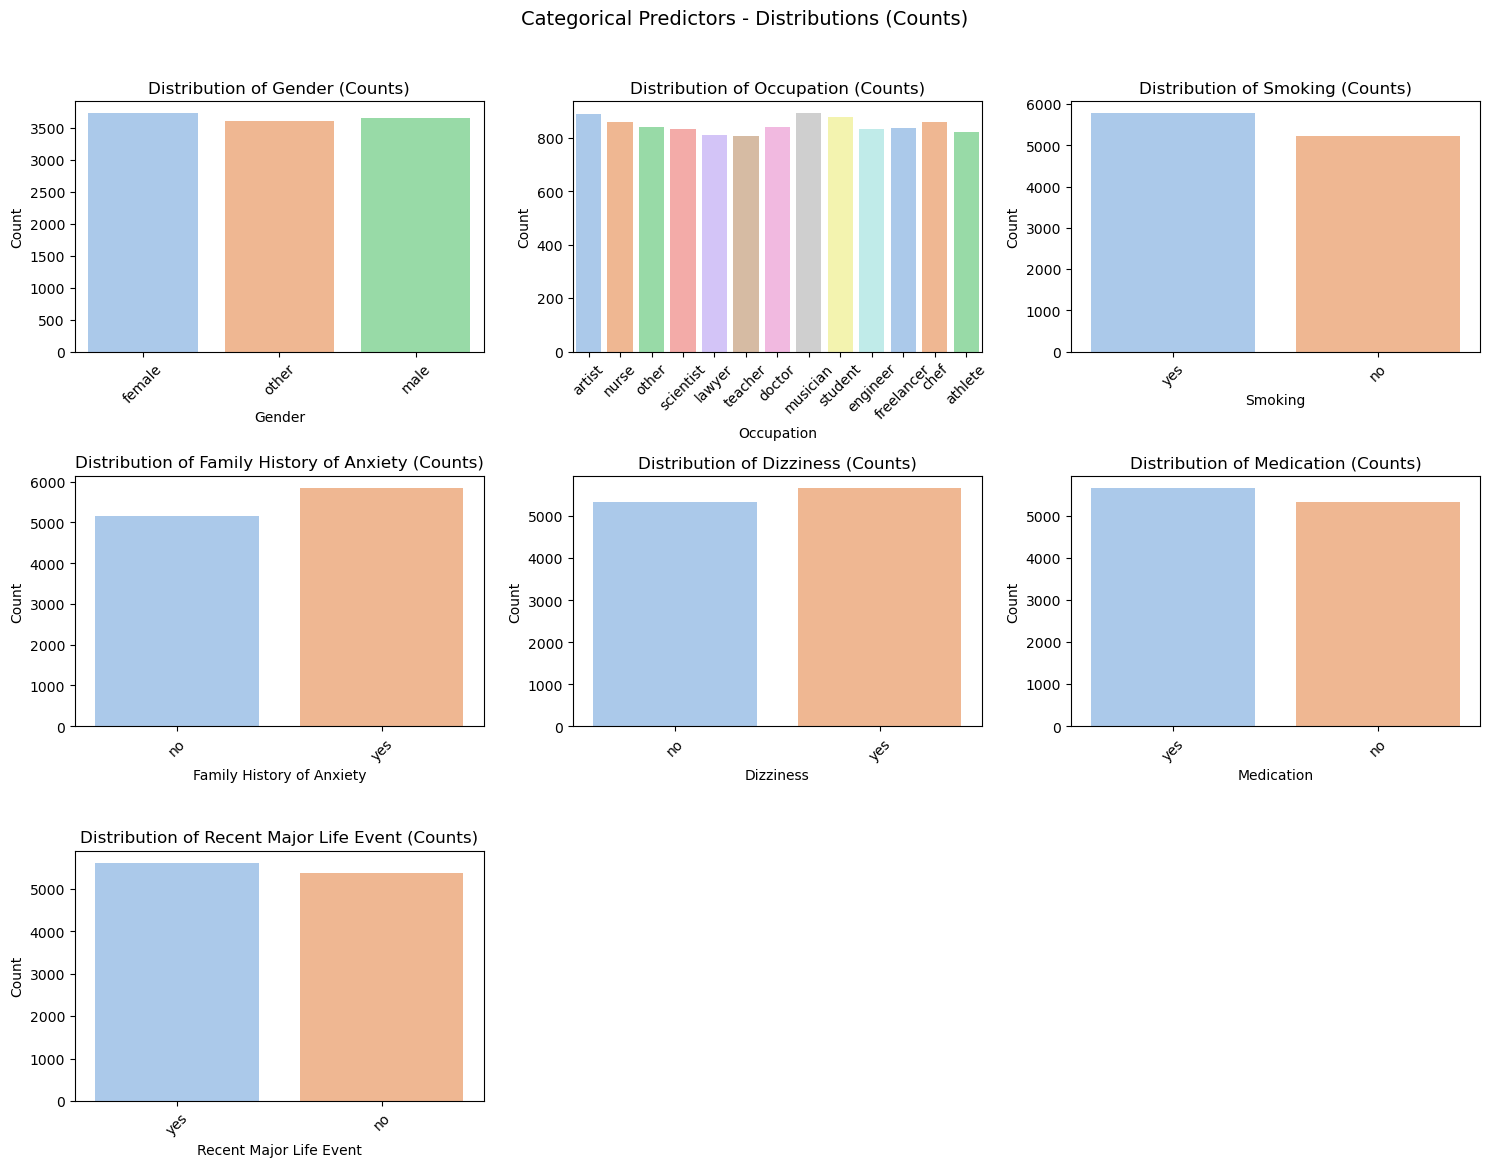

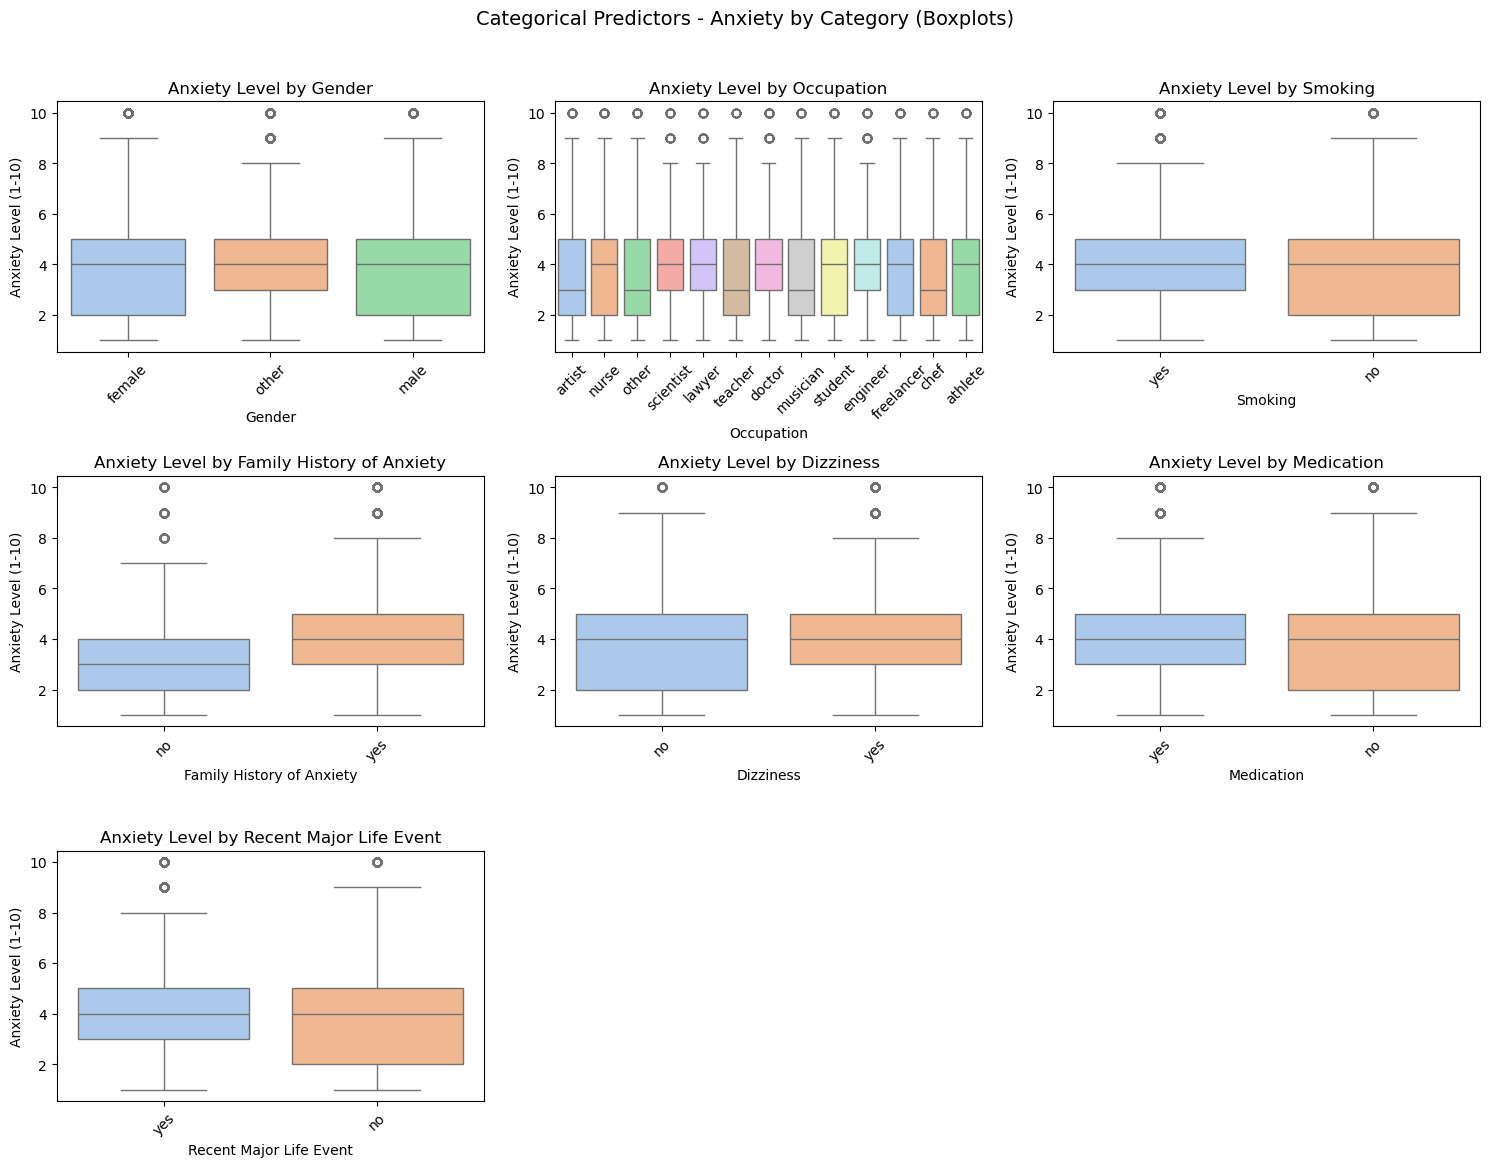

In [5]:
#Split numerical and categorical vars
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Anxiety Level (1-10)')
categorical_cols = df.select_dtypes(include='object').columns

#Ordinal-discrete numerics where KDE should be skipped
skip_kde = {'Sweating Level (1-5)', 'Diet Quality (1-10)'}

#Create histograms for numerical predictors in subplots
cols = 3
rows = math.ceil(len(numeric_cols) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.8*rows), squeeze=False)

for i, col in enumerate(numeric_cols):
    r, c = divmod(i, cols)
    ax = axes[r, c]

    series = df[col].dropna()
    mean_val = series.mean()
    counts, bin_edges = np.histogram(series, bins=15)
    bin_width = bin_edges[1] - bin_edges[0]

    sns.histplot(series, bins=15, kde=False, color='skyblue', ax=ax)

    if col not in skip_kde:
        x_smooth = np.linspace(bin_edges.min(), bin_edges.max(), 400)
        kde = gaussian_kde(series)
        y_smooth = kde(x_smooth) * len(series) * bin_width
        ax.plot(x_smooth, y_smooth, color='gold', linestyle='--', linewidth=2.0, label='KDE Trend')

    ax.axvline(mean_val, color='red', linestyle='-', linewidth=1.6, label=f'Mean = {mean_val:.2f}')
    ax.set_xlim(left=bin_edges.min())
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

handles, labels = axes[0,0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right', frameon=False)
fig.suptitle('Numeric Predictors - Histograms with KDE Trend + Mean', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#Create anxiety-by-binned-numeric box plots in subplots (auto-handle discrete vs continuous)
cols = 3
rows = math.ceil(len(numeric_cols) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.8*rows), squeeze=False)

for i, col in enumerate(numeric_cols):
    r, c = divmod(i, cols)
    ax = axes[r, c]

    if df[col].nunique() <= 10:
        sns.boxplot(x=col, y='Anxiety Level (1-10)', data=df, palette='Spectral',
                    hue=col, legend=False, ax=ax)
    else:
        binned = pd.cut(df[col], bins=8)
        sns.boxplot(x=binned, y='Anxiety Level (1-10)', data=df, palette='Spectral',
                    hue=binned, legend=False, ax=ax)

    ax.set_title(f'Anxiety Level by {col}' + ('' if df[col].nunique() <= 10 else ' (binned)'))
    ax.set_xlabel(col if df[col].nunique() <= 10 else f'{col} (binned)')
    ax.set_ylabel('Anxiety Level (1-10)')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

fig.suptitle('Numeric Predictors - Anxiety by Value (Discrete or Binned)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#Create bar charts of categorical counts in subplots
cols = 3
rows = math.ceil(len(categorical_cols) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.8*rows), squeeze=False)

for i, col in enumerate(categorical_cols):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    sns.countplot(x=col, data=df, palette='pastel', hue=df[col], legend=False, ax=ax)
    ax.set_title(f'Distribution of {col} (Counts)')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

fig.suptitle('Categorical Predictors - Distributions (Counts)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#Create box plots for categoricals in subplots
cols = 3
rows = math.ceil(len(categorical_cols) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.8*rows), squeeze=False)

for i, col in enumerate(categorical_cols):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    sns.boxplot(x=col, y='Anxiety Level (1-10)', data=df, palette='pastel',
                hue=col, legend=False, ax=ax)
    ax.set_title(f'Anxiety Level by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Anxiety Level (1-10)')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

fig.suptitle('Categorical Predictors - Anxiety by Category (Boxplots)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

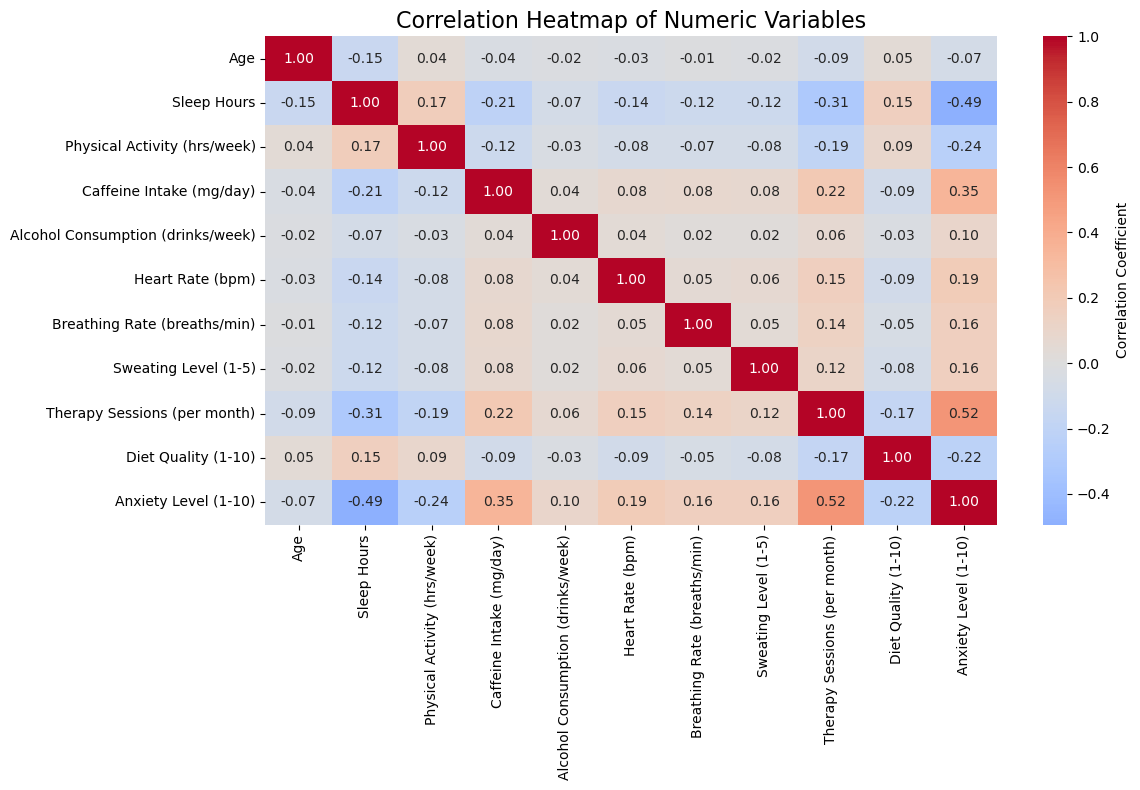

In [6]:
#Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

#Calculate correlation matrix
corr = numeric_df.corr()

#Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Numeric Variables', fontsize=16)
plt.tight_layout()
plt.show()

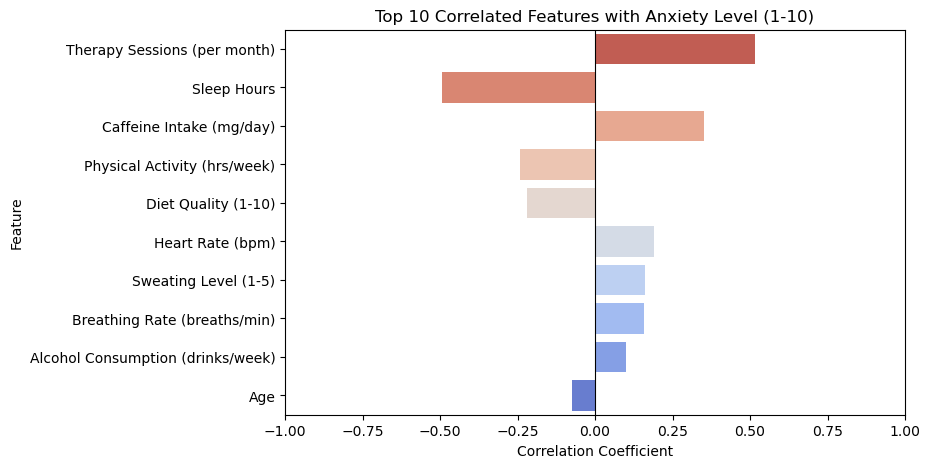

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

TARGET = 'Anxiety Level (1-10)'

#Calculate correlations with target
corr_series = df.corr(numeric_only=True)[TARGET].drop(TARGET)

#Sort by absolute correlation and take top 10
top_corr = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)[:10]

#Plot as bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm_r',  hue=top_corr.index)
plt.title(f'Top 10 Correlated Features with {TARGET}')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.xlim(-1, 1)  # full correlation scale
plt.axvline(0, color='black', linewidth=0.8)
plt.show()